<div align="center">

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dapivei/causal-infere/blob/main/sections/13_Difference_in_Differences.ipynb)

</div>


# Difference in Differences

## Recap From Last Class

+ Regression Discontinuity, Instrumental Variables

## Goals For Today

1. Understand the intuition behind Differences in Differences (DiD).
2. Implement DiD analysis using Python.
3. Visualize the results and interpret the coefficients.


##  Difference-in-Differences

## Consider a “2x2” DiD.

Let the outcomes $ Y_{g,t}(S, U) $ represent the observed values of an outcome variable, where:

$$\begin{aligned}
g=\left\{\begin{array}{l}
1 \text { if exposed to treatment $S$} \\
0 \text { if not }
\end{array}\right., \,
t =\left\{\begin{array}{l}
1 \text { post-treatment period} \\
0 \text { pre-treatment period  }
\end{array}\right., \,
S =\left\{\begin{array}{l}
1 \text { for treatment }\\
0 \text { no treatment }
\end{array}\right.
\end{aligned}$$

Difference-in-Differences (DiD) is a quasi-experimental design used to estimate causal effects of policy changes $S$ on an outcome of interest $ Y_{g,t}(S, U)$ by
> Comparing **changes over $t$** between a **$g=1$**  and a **$g=0$**.

This 2x2 DiD is limited to two periods and two groups. Extending $t$ to include multiple time periods would enable a more comprehensive evaluation of parallel trends.

### Assumptions
- **Parallel Trends**
In the absence of treatment $S=0$, both groups would have followed similar trends over time.
$$\mathbb{E}[Y_{1,1}(S =0,U)−Y_{1,0}(S =0,U)]
=\mathbb{E}[Y_{0,1}(S =0,U)−Y_{0,0}(S =0,U)]$$

Ensuring that any post-treatment divergence between the groups can be causally attributed to the intervention.

- **No Spillover Effects**: Treatment in one group must not influence outcomes in the other group.



### Identifying the Average Treatment on the Treated (ATT)


There are two equivalent ways to estimate the ATT under the parallel trends assumption:  
1. **Difference in Means (Naïve DiD)**.
Comparing the **change in outcomes for the treated group** against the **change for the control group**:

\begin{aligned}
   DiD&=\mathbb{E}[Y_{1,1}(S =1,U)]-\mathbb{E}[Y_{1,0}(S =0,U)]-
(\mathbb{E}[Y_{0,1}(S =0,U)]-\mathbb{E}[Y_{0,0}(S =0,U)])
\end{aligned}

where all terms are **observable**, making it implementable using sample means. **Recall that under the parallel trends assumption**,
$$DiD=ATT.$$
See class notes for proof.

2. **Regression-Based Estimation**.  Capturing differences across groups and time through an interaction term, define:

\begin{align}
G_i & =\left\{\begin{array}{l}
1 \text { if unit $i$ has been exposed to $S$ at some point } \\
0 \text { if not }
\end{array}\right. \\
T_t & =\left\{\begin{array}{l}
1 \text { if after treatment event } \\
0 \text { if before }
\end{array}\right. \\
D & =\left\{\begin{array}{l}
1 \text { if } T=1 \text { and } G=1 \\
0 \text { if not }
\end{array}\right.
\end{align}

The regression equation is:

>$$
Y_{it} = \beta_0 + \beta_1 \text{T}_t + \beta_2 \text{G}_i + \beta_3 (\text{T}_t \times \text{G}_i) + \epsilon_{it}
$$

where:
- $Y_{it}$: Outcome variable
- $\text{T}_t$: Binary variable for time (0 = pre-treatment, 1 = post-treatment)
- $\text{G}_i$: Binary variable for group (0 if not exposed, 1 if exposed to treatment)
- $\text{T}_t \times \text{G}_i$: Interaction term, capturing the DiD effect.

## Do increases in the minimum wage affect employment?

### Research Question: Does raising the minimum wage help workers by improving their earnings, or does it inadvertently harm them by reducing job opportunities?

There is an ambiguity about whether increasing the minimum wage is truly beneficial for workers overall:
* raising the minimum wage directly increases earnings for workers currently earning less than the new minimum, improving their financial stability.
* economic theory predicts that higher wages increase labor costs, leading employers to cut jobs or reduce hiring to offset these costs.


On 1992 New Jersey increased the minimum wage. **What was the effect of this rise on employment in fast-food restaurants?** [Card and Krueger (1994)](https://davidcard.berkeley.edu/papers/njmin-aer.pdf) investigate this!

### Model Setup

+ Unit of observation $g$: Restaurant, identified by location (NJ, 1 or PA, 0).
+ Time $t$: Period of observation (Pre-1992, 0 or Post-1992, 1).
+ Policy Intervention $S$: Minimum wage increase in NJ.
+ Outcome Variable $Y_{g,t}(S, U)$: Employment rate (e.g., number of employees) at restaurant $g$ at time $t$.


### The challenge

+ Do we know the counterfactual? Meaning the employment rate in NJ had it not implemented the minimum wage policy?
$$ATT = \mathbb{E}[Y_{1,1}(S =1,U)−Y_{1,1}(S =0,U)]$$
No, the fundamental problem of causal inference means half of the ATT is never directly observed
$\mathbb{E}[Y1,1(S = 0,U)]$.


+  Can we compare employment in NJ before and after the change?
$$\mathbb{E}\big[\text{Employ.}|\text{NJ}, \text{Post-92}\big]-\mathbb{E}\big[\text{Employ.}|\text{NJ}, \text{Pre-92}\big]$$
  + No, the pre-post comparison is confounded by a **time trend**.
+ Compare post-increase NJ unemployment to a bordering state who did not increase their minimum wage? Pennsylvania (PA) is a bordering state.
$$\mathbb{E}\big[\text{Employ.}|\text{NJ}, \text{Post-92}\big]-\mathbb{E}\big[\text{Employ.}|\text{PA}, \text{Post-92}\big]$$
  + No, the PA/NJ-comparison is confounded by the pre-change differences b/w the states.


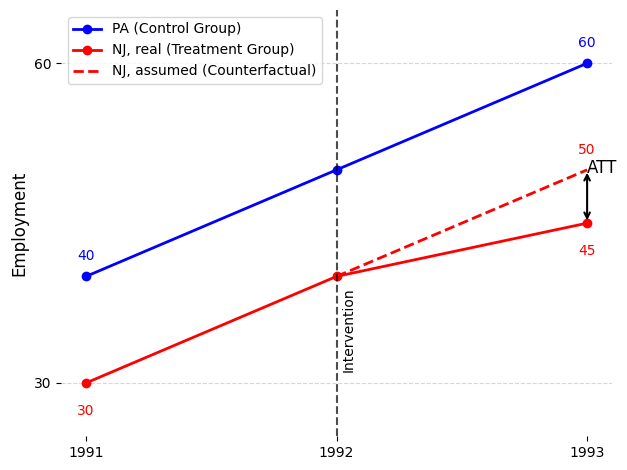

In [1]:
# @title
import matplotlib.pyplot as plt


# Define the data points
years = ['1991', '1992', '1993']
pa_values = [40, 50, 60]
nj_actual = [30, 40, 45]
nj_assumed = [30, 40, 50]

plt.plot(years, pa_values, label='PA (Control Group)', marker='o', color='blue', linewidth=2)

plt.plot(years, nj_actual, label='NJ, real (Treatment Group)', marker='o', color='red', linewidth=2)

plt.plot(years[1:], nj_assumed[1:], label='NJ, assumed (Counterfactual)', linestyle='--', color='red', linewidth=2)

plt.axvline(x=1, linestyle='--', color='black', alpha=0.7)  # Vertical dashed line at intervention
plt.text(1.02, 35, 'Intervention', color='black', fontsize=10, rotation=90, ha='left', va='center')


plt.text('1991', pa_values[0] + 1.5, str(pa_values[0]), color='blue', fontsize=10, ha='center')
plt.text('1993', pa_values[2] + 1.5, str(pa_values[2]), color='blue', fontsize=10, ha='center')

plt.text('1991', nj_actual[0] - 3, str(nj_actual[0]), color='red', fontsize=10, ha='center')
plt.text('1993', nj_actual[2] - 3, str(nj_actual[2]), color='red', fontsize=10, ha='center')

plt.text('1993', nj_assumed[2] + 1.5, str(nj_assumed[2]), color='red', fontsize=10, ha='center')

plt.annotate('', xy=('1993', nj_actual[2]), xytext=('1993', nj_assumed[2]),
             arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
plt.text('1993', (nj_actual[2] + nj_assumed[2]) / 2 + 2.2, 'ATT', color='black', ha='left', fontsize=12)

plt.ylabel('Employment', fontsize=12)
plt.xticks(range(len(years)), years, fontsize=10)
plt.yticks([30, 60], labels=['30', '60'], fontsize=10)
plt.ylim(25, 65)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()

plt.show()

### Data

In [2]:
import pandas as pd

df = pd.read_csv("../data/DID_Example.csv")
df.columns = df.columns.str.replace('.', '_', regex=False)
df['Time'] = df['Treatment']

In [3]:
df

,ID,Chain,SouthJ,CentralJ,NorthJ,PA1,PA2,Shore,Group,Empl,C_Owned,Hours_Opening,Soda,Fries,Treatment,Time
0,46,1,0,0,0,1,0,0,0,30.0,0,16.5,1.03,1.03,0,0
1,49,2,0,0,0,1,0,0,0,6.5,0,13.0,1.01,0.90,0,0
2,506,2,0,0,0,1,0,0,0,3.0,1,10.0,0.95,0.74,0,0
3,56,4,0,0,0,1,0,0,0,20.0,1,12.0,0.87,0.82,0,0
4,61,4,0,0,0,1,0,0,0,6.0,1,12.0,0.87,0.77,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,423,2,0,0,1,0,0,0,1,19.0,1,4.0,1.05,0.84,1,1
816,424,2,0,0,1,0,0,0,1,12.0,1,10.0,1.05,0.94,1,1
817,426,3,0,0,1,0,0,0,1,5.0,1,19.0,1.11,1.05,1,1
818,427,4,0,0,1,0,0,0,1,0.0,0,7.0,1.11,1.09,1,1


In [4]:
df.columns

Index(['ID', 'Chain', 'SouthJ', 'CentralJ', 'NorthJ', 'PA1', 'PA2', 'Shore',
       'Group', 'Empl', 'C_Owned', 'Hours_Opening', 'Soda', 'Fries',
       'Treatment', 'Time'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820 entries, 0 to 819
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             820 non-null    int64  
 1   Chain          820 non-null    int64  
 2   SouthJ         820 non-null    int64  
 3   CentralJ       820 non-null    int64  
 4   NorthJ         820 non-null    int64  
 5   PA1            820 non-null    int64  
 6   PA2            820 non-null    int64  
 7   Shore          820 non-null    int64  
 8   Group          820 non-null    int64  
 9   Empl           802 non-null    float64
 10  C_Owned        820 non-null    int64  
 11  Hours_Opening  820 non-null    float64
 12  Soda           790 non-null    float64
 13  Fries          775 non-null    float64
 14  Treatment      820 non-null    int64  
 15  Time           820 non-null    int64  
dtypes: float64(4), int64(12)
memory usage: 102.6 KB


In [6]:
df['Group'].value_counts()

Group
1    662
0    158
Name: count, dtype: int64

In [7]:
df['Time'].value_counts()

Time
0    410
1    410
Name: count, dtype: int64

In [8]:
df.groupby(['Time', 'Group']).size().reset_index(name='Counts')


,Time,Group,Counts
0,0,0,79
1,0,1,331
2,1,0,79
3,1,1,331




### Solution?

+ Compare how the difference in employment before and after 1992 differs b/w NJ and PA?
$$\text{DiD} = \big(\mathbb{E}\big[\text{Employ.}|\text{NJ}, \text{Post-92}\big]-\mathbb{E}\big[\text{Employ.}|\text{NJ}, \text{Pre-92}\big]\big) - \big(\mathbb{E}\big[\text{Employ.}|\text{PA}, \text{Post-92}\big] - \mathbb{E}\big[\text{Employ.}|\text{PA}, \text{Pre-92}\big]]\big)$$

  + Assuming that if NJ had not increased its minimum wage, its employment would have evolved the same way as PA's.


In [9]:
summary = df.pivot_table(index="Group", columns="Time", values="Empl")
nj_diff = summary.loc[1, 1] - summary.loc[1, 0]
pa_diff = summary.loc[0, 1] - summary.loc[0, 0]
did_estimate = nj_diff - pa_diff
print("Difference-in-Differences Estimate:", did_estimate)

Difference-in-Differences Estimate: 3.3617496258686552


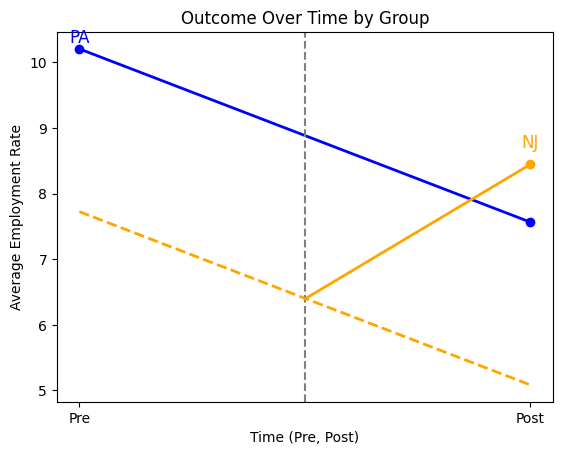

In [10]:
# @title

# Compute group means
group_means = df.groupby(['Time', 'Group'])['Empl'].mean().reset_index()

group_0 = group_means[group_means['Group'] == 0]
group_1 = group_means[group_means['Group'] == 1]

pre_treatment_group_0 = group_0[group_0['Time'] == 0]['Empl'].values[0]
pre_treatment_group_1 = group_1[group_1['Time'] == 0]['Empl'].values[0]

trend_diff = pre_treatment_group_1 - pre_treatment_group_0

parallel_group_1 = group_0.copy()
parallel_group_1['Empl'] = parallel_group_1['Empl'] + trend_diff

post_treatment_group_1 = group_1[group_1['Time'] >= 0.5]

parallel_at_0_5 = (summary.loc[0, 1] - summary.loc[0, 0] + 0.3) / 2 + summary.loc[0, 1]

actual_post_treatment_group_1 = post_treatment_group_1[post_treatment_group_1['Time'] == 1]['Empl'].values[0]

plt.plot(group_0['Time'], group_0['Empl'], marker='o', color='blue', linewidth=2)

plt.plot(parallel_group_1['Time'], parallel_group_1['Empl'], linestyle='--', color='orange', linewidth=2)

plt.plot(post_treatment_group_1['Time'], post_treatment_group_1['Empl'], marker='o', color='orange', linewidth=2)

plt.axvline(x=0.5, color='gray', linestyle='--')

plt.plot([0.5, 1], [parallel_at_0_5, actual_post_treatment_group_1], linestyle='-', color='orange', linewidth=2)

plt.title("Outcome Over Time by Group")
plt.xlabel("Time (Pre, Post)")
plt.ylabel("Average Employment Rate")

plt.xticks([0, 1], ['Pre', 'Post'])

plt.text(1, parallel_at_0_5 +2.3, "NJ", color='orange', fontsize=12, ha='center')

plt.text(0, pre_treatment_group_0 + 0.1, "PA", color='blue', fontsize=12, ha='center')

plt.show()







### Regression estimation


As shown above, we could also frame our problme in terms of a regression problem, where:

1. **Group variable ($G$)**:  
   $$
   G =
   \begin{cases}
   1 & \text{if restaurant is in NJ (treatment group)} \\
   0 & \text{if restaurant is in PA (control group)}
   \end{cases}
   $$
2. **Time variable ($T$)**:  
   $$
   T =
   \begin{cases}
   1 & \text{if after the minimum wage increase in NJ (post-treatment)} \\
   0 & \text{if before the minimum wage increase in NJ (pre-treatment)}
   \end{cases}
   $$

3. **Interaction term ($D$)**:  

   $$
   D = G \times T =
   \begin{cases}
   1 & \text{if the restaurant is in NJ after the wage increase (treated group, post-treatment)} \\
   0 & \text{otherwise}
   \end{cases}
   $$

Leading to:
$$
Y = \beta_0 + \beta_1 T + \beta_2 G + \beta_3 (T \times G) + \epsilon
$$


In [11]:
import statsmodels.formula.api as smf

# Run regression
model = smf.ols("Empl ~ Group + Time + Group*Time", data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Empl   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.122
Date:                Sun, 22 Dec 2024   Prob (F-statistic):             0.0959
Time:                        19:01:44   Log-Likelihood:                -2831.4
No. Observations:                 802   AIC:                             5671.
Df Residuals:                     798   BIC:                             5690.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.2051      0.938     10.883      0.0

Regardless of the method, we find that the minimum wage increase cause NJ fast food branches to increase employment by 3.36.


In [12]:
formula = """
Empl ~ Group + Treatment +
Treatment * Group + C_Owned +
Hours_Opening + Soda +
         Fries +
         C(Chain) +
         SouthJ +
         CentralJ +
         NorthJ +
         PA1 +
         PA2 +
         Shore
"""

reg = smf.ols(formula=formula, data=df).fit()

reg.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Empl   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     7.670
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           2.94e-15
Time:                        19:01:44   Log-Likelihood:                -2608.8
No. Observations:                 757   AIC:                             5248.
Df Residuals:                     742   BIC:                             5317.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.3236      3.414     -0.095      0.925      -7.025       6.378
C(Chain)[T.2]      -0.5951      1.089     -0.546      0.585      -2.733       1.543
C(Chain)[T.3]      -1.7984      0.907     -1.982      0.048      -3.580      -0.017
C(Chain)[T.4]       2.2299      1.055      2.114      0.035       0.160       4.300
Group              -1.7994      1.195     -1.505      0.133      -4.146       0.547
Treatment          -1.3162      1.293     -1.018      0.309      -3.855       1.223
Treatment:Group     4.1237      1.414      2.917      0.004       1.348       6.899
C_Owned            -0.1287      0.681     -0.189      0.850      -1.466       1.208
Hours_Opening       0.5499      0.099      5.579      0.000       0.356       0.743
Soda                2.7274      4.260      0.640      0.522      -5.635      11.090
Fries              -0.6461      4.065     -0.159      0.874      -8.627       7.335
SouthJ             -1.7821      0.561     -3.176      0.002      -2.884      -0.681
CentralJ           -0.6918      0.699     -0.989      0.323      -2.065       0.681
NorthJ              0.6744      0.679      0.994      0.321      -0.658       2.007
PA1                -0.4646      1.381     -0.336      0.737      -3.175       2.246
PA2                 1.9404      1.380      1.406      0.160      -0.769       4.650
Shore               0.8405      1.047      0.803      0.422      -1.214       2.895
==============================================================================
Omnibus:                      152.622   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              284.331
Skew:                           1.181   Prob(JB):                     1.81e-62
Kurtosis:                       4.855   Cond. No.                     1.03e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.35e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Does the Parallel Trends Hold?

1. Are the treated and untreated groups fundamentally “similar”?
2. Why did the treated group get the treatment (and why didn’t
the untreated group)?
3. Was the treatment event anticipated by the treated group?
4. Were there parallel trends in the pre-period?

#### Fallback
What if the Parallel Trends Assumption Does Not Hold? (We reject the parallel trends assumption)
1. matching/synthetic control method (weighted control groups to mimic the treated group)
2. Regression Discontinuity Design (RDD)
3. Instrumental Variables (IV)

### Time Varying Treatment Effects


Are the effects varying? Meaning the minimum wage increase on employment varies over time, initially increasing employment but eventually decreasing as firms substitute workers with machines?

Our model can capture this dynamic with multiple time periods $t$:

$$
Y_{g, t} = \sum_{i=-\underline{t}}^{\bar{t}} \beta_i T_i + \gamma G + \sum_{j=0}^{\bar{t}} \alpha_j D_j \\
\alpha_j = A T T_j
$$

- $\beta_i$ captures general time trends
- $\gamma$ represents the difference between treated and untreated groups.
- $\alpha_j$ estimates the time-varying Average Treatment Effects on the Treated (ATTs).


### (Recall) Standard Errors of Linear Regression

#### Robust Standard Errors

\begin{align}
V_{\text {robust }}=\left(X^{T} X\right)^{-1} X^{T} \Omega X\left(X^{T} X\right)^{-1},
\end{align}


#### Cluster-Robust Standard Errors
Recall: iid residuals are not realistic in most cases, but we can assume the residuals are **clustered** by the group, which means between-group correlation is zero, but within-group correlation is positive. Block diagonal matrix $\Omega$.


\begin{align}
V_{\text {clustered }}=\left(X^{T} X\right)^{-1}\left(\sum_{c=1}^C X_c^{T} \hat{u}_c \hat{u}_c^{T} X_c\right)\left(X^{T} X\right)^{-1}
\end{align}


where $\Omega$ is a block diagonal matrix with each block being the covariance matrix of the residuals within each cluster.


you need to provide the clusters.


$$
\begin{align}
\operatorname{Cov}\left(Y_{i, g, t}, Y_{i, g, t+1}\right)>0
\end{align}
$$

We need to use cluster-robust standard errors to account for the auto-correlation along the time dimension.

For clustered standard errors to make sense, we need:
- Each cluster is independent of the other clusters
- A large number of clusters (both treated and untreated)

#### Permutation Test

## Path Forward

+ Recap of methods learned in this class, and wrap up!


---

**References:**

+ Tutorials:
  + https://rpubs.com/phle/r_tutorial_difference_in_differences
  +  https://bookdown.org/cuborican/RE_STAT/difference-in-differences.html

+ Card, David and Alan B. Krueger. 1994. “Minimum Wages
and Employment: A Case Study of the Fast-Food Industry in
New Jersey and Pennsylvania.” The American Economic
Review 84 (4): 772-793.
https://www.jstor.org/stable/2677856.

+ Sah, Sidharth. Causal Inference: Difference-in-Differences. 2024. PowerPoint presentation.